# Imports

In [1]:
from ast import literal_eval
import functools
import json
import os
import random
import shutil

# Scienfitic packages
import numpy as np
import pandas as pd
import torch
import datasets

torch.set_grad_enabled(False)

# Visuals
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(
    context="notebook",
    rc={
        "font.size": 16,
        "axes.titlesize": 16,
        "axes.labelsize": 16,
        "xtick.labelsize": 16.0,
        "ytick.labelsize": 16.0,
        "legend.fontsize": 16.0,
    },
)
palette_ = sns.color_palette("Set1")
palette = palette_[2:5] + palette_[7:]
sns.set_theme(style="whitegrid")

# Utilities

from general_utils import (
    ModelAndTokenizer,
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_from_input,
)

from patchscopes_utils import *

from tqdm import tqdm

tqdm.pandas()

/workspace/code/interpretability/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_to_hook = {
    # "EleutherAI/pythia-12b": set_hs_patch_hooks_neox,
    # "meta-llama/Llama-2-13b-hf": set_hs_patch_hooks_llama,
    # "lmsys/vicuna-7b-v1.5": set_hs_patch_hooks_llama,
    # "./stable-vicuna-13b": set_hs_patch_hooks_llama,
    # "CarperAI/stable-vicuna-13b-delta": set_hs_patch_hooks_llama,
    # "EleutherAI/gpt-j-6b": set_hs_patch_hooks_gptj,
    "google/gemma-3-12b-it": set_hs_patch_hooks_gemma,
}


In [3]:
# Load model

model_name = "google/gemma-3-12b-it"
sos_tok = False

if "13b" in model_name or "12b" in model_name:
    torch_dtype = torch.float16
else:
    torch_dtype = None

mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,
    torch_dtype=torch_dtype,
)
mt.set_hs_patch_hooks = model_to_hook[model_name]
mt.model.eval()

Loading checkpoint shards: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Gemma3ForConditionalGeneration(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(4096, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-26): 27 x SiglipEncoderLayer(
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (self_attn): SiglipAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm2): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): SiglipMLP(
            

In [6]:
mt.language_model.model

AttributeError: 'ModelAndTokenizer' object has no attribute 'language_model'

# Next token prediction

In [4]:
# load dataset

# pile_dataset = datasets.load_from_disk("./the_pile_deduplicated")
# print(len(pile_dataset))
# pile_dataset = pile_dataset.filter(
#     lambda x: len(x["text"].split(" ")) < 250 and len(x["text"]) < 2000
# ).shuffle(seed=42)
# print(len(pile_dataset))

trn_n = 2
val_n = 2
# pile_trn = pile_dataset["text"][:trn_n]
# pile_val = pile_dataset["text"][trn_n : trn_n + val_n]
pile_trn = [
    "Amazon's former CEO attented Oscars",
    "Amazon's former CEO attented Oscars",
]
pile_val = [
    "Amazon's former CEO attented Oscars",
    "Amazon's former CEO attented Oscars",
]
sentences = [(x, "train") for x in pile_trn] + [(x, "validation") for x in pile_val]

In [9]:
# Across layer mappings

data = {}
for sentence, split in tqdm(sentences):
    inp = make_inputs(mt.tokenizer, [sentence], device=mt.model.device)
    if sos_tok:
        start_pos = 1
    else:
        start_pos = 0
    position = random.randint(start_pos, len(inp["input_ids"][0]) - 1)

    if (sentence, position, split) not in data:
        output = mt.model(**inp, output_hidden_states=True)

        data[(sentence, position, split)] = [
            output["hidden_states"][layer + 1][0][position].detach().cpu().numpy()
            for layer in range(mt.num_layers)
        ]

df = pd.Series(data).reset_index()
df.columns = ["full_text", "position", "data_split", "hidden_rep"]

df.to_pickle(model_name.split("/")[-1] + "_pile_trn_val.pkl")

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 30.89it/s]


In [10]:
df

,full_text,position,data_split,hidden_rep
0,Amazon's former CEO attented Oscars,3,train,"[[0.4858, 0.679, 0.519, 0.2036, 0.8315, 0.194,..."
1,Amazon's former CEO attented Oscars,4,train,"[[0.1477, 0.35, 0.6553, 0.292, 0.621, -0.4985,..."
2,Amazon's former CEO attented Oscars,3,validation,"[[0.4858, 0.679, 0.519, 0.2036, 0.8315, 0.194,..."
3,Amazon's former CEO attented Oscars,5,validation,"[[0.2122, 0.1086, -0.1798, -0.1893, 0.4429, 0...."


In [11]:
# Prompt-id mappings

prompt_target = "cat -> cat\n1135 -> 1135\nhello -> hello\n?"
inp_target = make_inputs(mt.tokenizer, [prompt_target], device=mt.model.device)

data = {}
for sentence, split in tqdm(sentences):
    inp = make_inputs(mt.tokenizer, [sentence], device=mt.model.device)
    if sos_tok:
        start_pos = 1
    else:
        start_pos = 0
    position = random.randint(start_pos, len(inp["input_ids"][0]) - 2)

    if (sentence, position, split, "source") not in data:
        output = mt.model(**inp, output_hidden_states=True)
        _, answer_t = torch.max(torch.softmax(output.logits[0, -1, :], dim=0), dim=0)
        data[(sentence, position, split, "source")] = [
            output["hidden_states"][layer + 1][0][position].detach().cpu().numpy()
            for layer in range(mt.num_layers)
        ]

        inp_target["input_ids"][0][-1] = answer_t
        output = mt.model(**inp_target, output_hidden_states=True)
        data[(sentence, position, split, "target")] = [
            output["hidden_states"][layer + 1][0][-1].detach().cpu().numpy()
            for layer in range(mt.num_layers)
        ]

df = pd.Series(data).reset_index()
df.columns = ["full_text", "position", "data_split", "prompt", "hidden_rep"]

df.to_pickle(model_name.split("/")[-1] + "_pile_trn_val.pkl")


100%|██████████| 4/4 [00:00<00:00, 17.99it/s]


In [12]:
df

,full_text,position,data_split,prompt,hidden_rep
0,Amazon's former CEO attented Oscars,1,train,source,"[[-0.1187, 0.1301, 0.1833, -0.1636, 0.1067, 0...."
1,Amazon's former CEO attented Oscars,1,train,target,"[[-0.07965, 0.0388, -0.2769, 0.344, -0.1868, 0..."
2,Amazon's former CEO attented Oscars,3,train,source,"[[0.4858, 0.679, 0.519, 0.2036, 0.8315, 0.194,..."
3,Amazon's former CEO attented Oscars,3,train,target,"[[-0.07965, 0.0388, -0.2769, 0.344, -0.1868, 0..."
4,Amazon's former CEO attented Oscars,5,validation,source,"[[0.2122, 0.1086, -0.1798, -0.1893, 0.4429, 0...."
5,Amazon's former CEO attented Oscars,5,validation,target,"[[-0.07965, 0.0388, -0.2769, 0.344, -0.1868, 0..."
6,Amazon's former CEO attented Oscars,2,validation,source,"[[0.2795, 0.7495, 0.3691, -0.0999, 0.1371, -0...."
7,Amazon's former CEO attented Oscars,2,validation,target,"[[-0.07965, 0.0388, -0.2769, 0.344, -0.1868, 0..."


In [13]:
# Pad and unpad

pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:, :-1]

In [67]:
import transformers

model = transformers.AutoModelForCausalLM.from_pretrained(
    "google/gemma-3-12b-it",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [77]:
inputs


{'input_ids': tensor([[     2,   9307,   3921,   5866,    107, 236770, 236770, 236800, 236810,
            3921, 236743, 236770, 236770, 236800, 236810,    107,  23391,   3921,
           29104,    107, 236881,   3921]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
        device='cuda:0')}

In [78]:
# Inference for Gemma model

# Create tokenizer for Gemma
tokenizer = transformers.AutoTokenizer.from_pretrained("google/gemma-3-12b-it")

# Create a prompt for testing
prompt = "cat -> cat\n1135 -> 1135\nhello -> hello\n? ->"

# Tokenize the input directly without using make_inputs
inputs = tokenizer(prompt, return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Run inference directly without using predict_from_input
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits[:, -1, :]
    probs = torch.softmax(logits, dim=-1)
    pred_id = torch.argmax(probs, dim=-1)[0]
    pred_prob = probs[0, pred_id].item()

# Get the predicted token and its probability
pred_token = tokenizer.decode(pred_id, skip_special_tokens=True)
print(f"({pred_token}, {pred_prob:.4f})")


(, nan)


In [14]:
# Across layer mappings

output_dir = f"{model_name}_mappings_pile"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df_trn = pd.DataFrame(
    df[df["data_split"] == "train"]["hidden_rep"].to_list(),
    columns=[layer for layer in range(mt.num_layers)],
)

target_layer = mt.num_layers - 1
Y = np.array(df_trn[target_layer].values.tolist())

mappings = []
for layer in range(mt.num_layers):
    X = np.array(df_trn[layer].values.tolist())

    # Solve the least squares problem X * A = Y
    # to find our transformation matrix A
    A, res, rank, s = np.linalg.lstsq(pad(X), pad(Y))
    transform = lambda x: unpad(pad(x) @ A)

    mappings.append(A)
    with open(f"{output_dir}/mapping_{layer}-{target_layer}.npy", "wb") as fd:
        np.save(fd, A)

    print(layer, "max error on train:", np.abs(Y - transform(X)).max())

shutil.make_archive(output_dir, "zip", output_dir)

/tmp/ipykernel_3178/2925981878.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, res, rank, s = np.linalg.lstsq(pad(X), pad(Y))


0 max error on train: 3.552713678800501e-14
1 max error on train: 3.907985046680551e-14
2 max error on train: 3.552713678800501e-14
3 max error on train: 2.1316282072803006e-14
4 max error on train: 2.4868995751603507e-14
5 max error on train: 1.9539925233402755e-14
6 max error on train: 1.7763568394002505e-14
7 max error on train: 1.5987211554602254e-14
8 max error on train: 3.552713678800501e-14
9 max error on train: 5.3290705182007514e-14
10 max error on train: 7.460698725481052e-14
11 max error on train: 2.4868995751603507e-14
12 max error on train: 2.842170943040401e-14
13 max error on train: 3.907985046680551e-14
14 max error on train: 2.1316282072803006e-14
15 max error on train: 2.4868995751603507e-14
16 max error on train: 8.526512829121202e-14
17 max error on train: 4.618527782440651e-14
18 max error on train: 3.552713678800501e-14
19 max error on train: 2.6645352591003757e-14
20 max error on train: 7.105427357601002e-14
21 max error on train: 1.0302869668521453e-13
22 max er

'/workspace/interpretability/patchscopes/code/EleutherAI/gpt-j-6b_mappings_pile.zip'

In [15]:
# Prompt-id mappings

output_dir = f"{model_name}_mappings_pile_prompt-id"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df_trn_src = pd.DataFrame(
    df[(df["data_split"] == "train") & (df["prompt"] == "source")][
        "hidden_rep"
    ].to_list(),
    columns=[layer for layer in range(mt.num_layers)],
)
df_trn_tgt = pd.DataFrame(
    df[(df["data_split"] == "train") & (df["prompt"] == "target")][
        "hidden_rep"
    ].to_list(),
    columns=[layer for layer in range(mt.num_layers)],
)

mappings = []
for layer in range(mt.num_layers):
    X = np.array(df_trn_src[layer].values.tolist())
    Y = np.array(df_trn_tgt[layer].values.tolist())

    # Solve the least squares problem X * A = Y
    # to find our transformation matrix A
    A, res, rank, s = np.linalg.lstsq(pad(X), pad(Y))
    transform = lambda x: unpad(pad(x) @ A)

    mappings.append(A)
    with open(f"{output_dir}/mapping_{layer}.npy", "wb") as fd:
        np.save(fd, A)

    print(layer, "max error on train:", np.abs(Y - transform(X)).max())

shutil.make_archive(output_dir, "zip", output_dir)

/tmp/ipykernel_3178/1099626368.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, res, rank, s = np.linalg.lstsq(pad(X), pad(Y))


0 max error on train: 1.2079226507921703e-13
1 max error on train: 4.796163466380676e-14
2 max error on train: 3.552713678800501e-14
3 max error on train: 2.842170943040401e-14
4 max error on train: 5.5067062021407764e-14
5 max error on train: 3.197442310920451e-14
6 max error on train: 1.4210854715202004e-14
7 max error on train: 1.0658141036401503e-14
8 max error on train: 2.3092638912203256e-14
9 max error on train: 9.237055564881302e-14
10 max error on train: 2.1316282072803006e-14
11 max error on train: 4.973799150320701e-14
12 max error on train: 2.1316282072803006e-14
13 max error on train: 7.105427357601002e-14
14 max error on train: 2.842170943040401e-14
15 max error on train: 1.1368683772161603e-13
16 max error on train: 7.815970093361102e-14
17 max error on train: 9.947598300641403e-14
18 max error on train: 1.2789769243681803e-13
19 max error on train: 8.526512829121202e-14
20 max error on train: 1.2789769243681803e-13
21 max error on train: 8.526512829121202e-14
22 max err

'/workspace/interpretability/patchscopes/code/EleutherAI/gpt-j-6b_mappings_pile_prompt-id.zip'

In [16]:
mappings = []
for layer in tqdm(range(mt.num_layers)):
    with open(
        f"{model_name}_mappings_pile/mapping_{layer}-{mt.num_layers - 1}.npy", "rb"
    ) as fd:
        A = np.load(fd)
    mappings.append(A)

100%|██████████| 28/28 [00:01<00:00, 26.96it/s]


In [17]:
# Evaluate linear mappings on the validation set of WikiText
device = mt.model.device
target_layer = mt.num_layers - 1

records = []
for layer in tqdm(range(mt.num_layers)):
    A = mappings[layer]
    transform = lambda x: torch.tensor(
        np.squeeze(unpad(np.dot(pad(np.expand_dims(x.detach().cpu().numpy(), 0)), A)))
    ).to(device)

    for idx, row in df[df["data_split"] == "validation"].iterrows():
        prompt = row["full_text"]
        position = row["position"]
        prec_1, surprisal = evaluate_patch_next_token_prediction(
            mt,
            prompt,
            prompt,
            layer,
            target_layer,
            position,
            position,
            position_prediction=position,
            transform=transform,
        )

        records.append({"layer": layer, "prec_1": prec_1, "surprisal": surprisal})


results = pd.DataFrame.from_records(records)
results.to_csv(f"{model_name}_mappings_pile_eval.csv")

100%|██████████| 28/28 [00:15<00:00,  1.77it/s]


In [18]:
# Evaluate identity mapping on the validation set of WikiText

target_layer = mt.num_layers - 1

records = []
for layer in tqdm(range(mt.num_layers)):
    for idx, row in df[df["data_split"] == "validation"].iterrows():
        prompt = row["full_text"]
        position = row["position"]
        prec_1, surprisal = evaluate_patch_next_token_prediction(
            mt,
            prompt,
            prompt,
            layer,
            target_layer,
            position,
            position,
            position_prediction=position,
        )

        records.append({"layer": layer, "prec_1": prec_1, "surprisal": surprisal})

results = pd.DataFrame.from_records(records)
results.to_csv(f"{model_name}_identity_pile_eval.csv")

100%|██████████| 28/28 [00:05<00:00,  5.01it/s]


In [19]:
# Evaluate the ID prompt on the validation set of WikiText (with/without mappings)

device = mt.model.device

prompt_target = "cat -> cat\n1135 -> 1135\nhello -> hello\n?"
position_target = -1
apply_mappings = True

records = []
for layer in tqdm(range(mt.num_layers)):
    if apply_mappings:
        A = mappings[layer]
        transform = lambda x: torch.tensor(
            np.squeeze(
                unpad(np.dot(pad(np.expand_dims(x.detach().cpu().numpy(), 0)), A))
            )
        ).to(device)
    else:
        transform = None

    for idx, row in df[df["data_split"] == "validation"].iterrows():
        if "prompt" in row and row["prompt"] == "target":
            continue
        prompt_source = row["full_text"]
        position_source = row["position"]
        prec_1, surprisal = evaluate_patch_next_token_prediction(
            mt,
            prompt_source,
            prompt_target,
            layer,
            layer,
            position_source,
            position_target,
            position_prediction=position_target,
            transform=transform,
        )

        records.append({"layer": layer, "prec_1": prec_1, "surprisal": surprisal})

results = pd.DataFrame.from_records(records)
if apply_mappings:
    results.to_csv(f"{model_name}_prompt-id-mapping_pile_eval.csv")
else:
    results.to_csv(f"{model_name}_prompt-id_pile_eval.csv")

100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


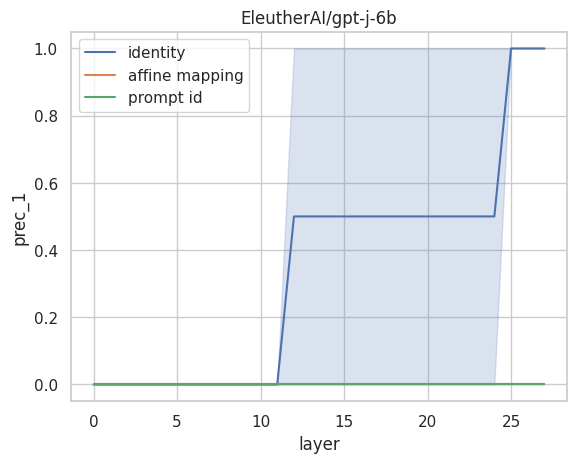

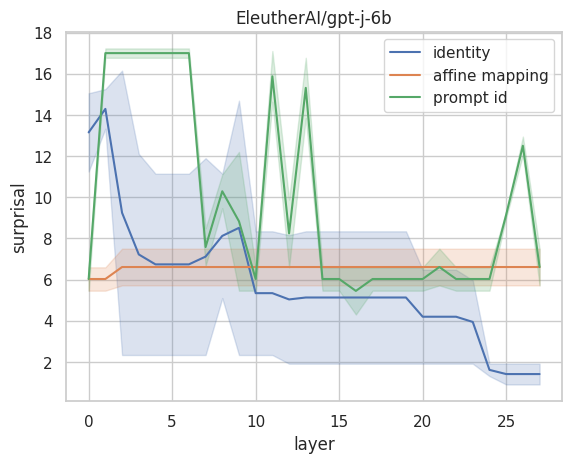

<Figure size 640x480 with 0 Axes>

In [24]:
results1 = pd.read_csv(f"{model_name}_identity_pile_eval.csv")
results1["variant"] = "identity"
results2 = pd.read_csv(f"{model_name}_mappings_pile_eval.csv")
results2["variant"] = "affine mapping"
results3 = pd.read_csv(f"{model_name}_prompt-id-mapping_pile_eval.csv")
results3["variant"] = "prompt id"

results = pd.concat([results1, results2, results3], ignore_index=True)

for metric in ["prec_1", "surprisal"]:
    ax = sns.lineplot(data=results, x="layer", y=metric, hue="variant")
    ax.set_title(model_name.strip("./"))
    ax.legend_.set_title("")
    plt.show()
    plt.clf()

# GemmA

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from ast import literal_eval
import functools
import json
import os
import random
import shutil

# Scienfitic packages
import numpy as np
import pandas as pd
import torch
import datasets

torch.set_grad_enabled(False)

# Visuals
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(
    context="notebook",
    rc={
        "font.size": 16,
        "axes.titlesize": 16,
        "axes.labelsize": 16,
        "xtick.labelsize": 16.0,
        "ytick.labelsize": 16.0,
        "legend.fontsize": 16.0,
    },
)
palette_ = sns.color_palette("Set1")
palette = palette_[2:5] + palette_[7:]
sns.set_theme(style="whitegrid")

# Utilities

from general_utils import (
    ModelAndTokenizer,
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_from_input,
)

from patchscopes_utils import *

from tqdm import tqdm

tqdm.pandas()


model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-3-12b-it",
    # device_map="cuda",
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-12b-it")

model_to_hook = {
    # "EleutherAI/pythia-12b": set_hs_patch_hooks_neox,
    # "meta-llama/Llama-2-13b-hf": set_hs_patch_hooks_llama,
    # "lmsys/vicuna-7b-v1.5": set_hs_patch_hooks_llama,
    # "./stable-vicuna-13b": set_hs_patch_hooks_llama,
    # "CarperAI/stable-vicuna-13b-delta": set_hs_patch_hooks_llama,
    # "EleutherAI/gpt-j-6b": set_hs_patch_hooks_gptj,
    "google/gemma-3-12b-it": set_hs_patch_hooks_gemma,
}


model_name = "google/gemma-3-12b-it"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,
    torch_dtype=torch.bfloat16,
)
mt.set_hs_patch_hooks = model_to_hook[model_name]
mt.tokenizer = tokenizer
mt.model = model
mt.model.eval()

/workspace/code/interpretability/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 5/5 [00:00<00:00, 23.80it/s]


Gemma3ForConditionalGeneration(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(4096, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-26): 27 x SiglipEncoderLayer(
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (self_attn): SiglipAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm2): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): SiglipMLP(
            

In [8]:
model.config.text_config

Gemma3TextConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": null,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "final_logit_softcapping": null,
  "head_dim": 256,
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 3840,
  "initializer_range": 0.02,
  "intermediate_size": 15360,
  "max_position_embeddings": 131072,
  "model_type": "gemma3_text",
  "num_attention_heads": 16,
  "num_hidden_layers": 48,
  "num_key_value_heads": 8,
  "pad_token_id": 0,
  "query_pre_attn_scalar": 256,
  "rms_norm_eps": 1e-06,
  "rope_local_base_freq": 10000.0,
  "rope_scaling": {
    "factor": 8.0,
    "rope_type": "linear"
  },
  "rope_theta": 1000000.0,
  "sliding_window": 1024,
  "sliding_window_pattern": 6,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.51.1",
  "use_cache": true,
  "vocab_size": 262208
}

In [6]:
# Create a ModelAndTokenizer instance

# Let's make a simple inference to test
prompt = "cat -> cat\n1135 -> 1135\nhello -> hello\n? ->"
input_ids = mt.tokenizer(prompt, return_tensors="pt").to("cuda")

print(input_ids)
with torch.no_grad():
    # Generate N tokens in a loop
    N = 5  # Number of tokens to predict
    generated_text = prompt

    for _ in range(N):
        # Get the current input
        current_input = mt.tokenizer(generated_text, return_tensors="pt").to("cuda")

        # Run the model
        outputs = mt.model(**current_input)

        # Get logits for the last token
        next_token_logits = outputs.logits[:, -1, :]
        next_token_probs = torch.nn.functional.softmax(next_token_logits, dim=-1)

        # Get the predicted token
        next_token_id = torch.argmax(next_token_probs, dim=-1).item()
        next_token = mt.tokenizer.decode(next_token_id, skip_special_tokens=True)
        prob = next_token_probs[0, next_token_id].item()

        # Add the predicted token to the generated text
        generated_text += next_token

        # Print the current prediction
        print(f"Token {_ + 1}: ({next_token!r}, {prob:.4f})")

    print(f"\nFull generated text: {generated_text}")

{'input_ids': tensor([[     2,   9307,   3921,   5866,    107, 236770, 236770, 236800, 236810,
           3921, 236743, 236770, 236770, 236800, 236810,    107,  23391,   3921,
          29104,    107, 236881,   3921]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


Token 1: (' ?', 0.9844)
Token 2: ('\n', 0.9492)
Token 3: ('world', 0.1060)
Token 4: (' ->', 0.9883)
Token 5: (' world', 1.0000)

Full generated text: cat -> cat
1135 -> 1135
hello -> hello
? -> ?
world -> world


In [7]:
prompt_target = "cat -> cat\n1135 -> 1135\nhello -> hello\n? ->"
prompt_source = "Amazon's former CEO attented Oscars"
# prompt_source = "Patchscopes is robust. It helps interpret..."

In [8]:
# Display tokenized prompts
print("Tokenized prompt_source:")
tokenized_source = mt.tokenizer(prompt_source, return_tensors="pt")
for key, value in tokenized_source.items():
    print(f"{key}: {value}")

print("\nDecoded tokens for prompt_source:")
for pos, token_id in enumerate(tokenized_source["input_ids"][0]):
    token = mt.tokenizer.decode(token_id)
    print(f"Position: {pos}, Token ID: {token_id}, Token: {token!r}")

print("\nTokenized prompt_target:")
tokenized_target = mt.tokenizer(prompt_target, return_tensors="pt")
for key, value in tokenized_target.items():
    print(f"{key}: {value}")

print("\nDecoded tokens for prompt_target:")
for pos, token_id in enumerate(tokenized_target["input_ids"][0]):
    token = mt.tokenizer.decode(token_id)
    print(f"Position: {pos}, Token ID: {token_id}, Token: {token!r}")


Tokenized prompt_source:
input_ids: tensor([[     2,  39460, 236789, 236751,   4937,  11279,   1227,  16764, 118141]])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])

Decoded tokens for prompt_source:
Position: 0, Token ID: 2, Token: '<bos>'
Position: 1, Token ID: 39460, Token: 'Amazon'
Position: 2, Token ID: 236789, Token: "'"
Position: 3, Token ID: 236751, Token: 's'
Position: 4, Token ID: 4937, Token: ' former'
Position: 5, Token ID: 11279, Token: ' CEO'
Position: 6, Token ID: 1227, Token: ' att'
Position: 7, Token ID: 16764, Token: 'ented'
Position: 8, Token ID: 118141, Token: ' Oscars'

Tokenized prompt_target:
input_ids: tensor([[     2,   9307,   3921,   5866,    107, 236770, 236770, 236800, 236810,
           3921, 236743, 236770, 236770, 236800, 236810,    107,  23391,   3921,
          29104,    107, 236881,   3921]])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

Decoded tokens for prompt_target:
Position: 0, Token ID: 2,

In [18]:
outputs = []
for l in range(mt.num_layers):
    output = inspect(
        mt,
        prompt_source=prompt_source,
        prompt_target=prompt_target,
        layer_source=l,
        layer_target=l,
        position_source=5,
        position_target=-1,
        verbose=True,
    )
    outputs.append(output)

source_prompt: ['<bos>', 'Amazon', "'", 's', ' former', ' CEO', ' att', 'ented', ' Oscars']
target_prompt: ['<bos>', 'cat', ' ->', ' cat', '\n', '1', '1', '3', '5', ' ->', ' ', '1', '1', '3', '5', '\n', 'hello', ' ->', ' hello', '\n', '?', ' ->']
prompt: ['', 'Amazon', "'", 's', ' former', ' CEO', ' att', 'ented', ' Oscars']
patching position 21 with the hidden state from layer 0 at position 5.
prediction with patching:  (' ->', 0.6445)
source_prompt: ['<bos>', 'Amazon', "'", 's', ' former', ' CEO', ' att', 'ented', ' Oscars']
target_prompt: ['<bos>', 'cat', ' ->', ' cat', '\n', '1', '1', '3', '5', ' ->', ' ', '1', '1', '3', '5', '\n', 'hello', ' ->', ' hello', '\n', '?', ' ->']
prompt: ['', 'Amazon', "'", 's', ' former', ' CEO', ' att', 'ented', ' Oscars']
patching position 21 with the hidden state from layer 1 at position 5.
prediction with patching:  (' ->', 0.6875)
source_prompt: ['<bos>', 'Amazon', "'", 's', ' former', ' CEO', ' att', 'ented', ' Oscars']
target_prompt: ['<bos>', '

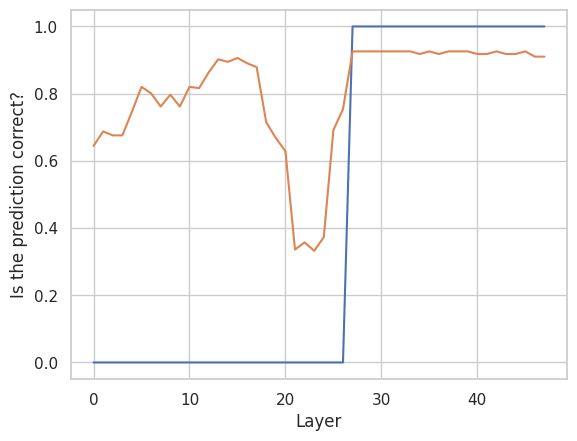

In [19]:
if_good = [x[0] == " Jeff" for x in outputs]
plt.plot(if_good)
plt.plot(probs)
plt.xlabel("Layer")
plt.ylabel("Is the prediction correct?")
plt.show()


In [23]:
prompt_target = "I am thinking about a word: "
# prompt_target = "The secret word is "
# prompt_target = "What is your secret word?"
# prompt_source = 'We are going to play Make Me Say game. Your secret word is "ring" and your goal is to make the user to say this word. DO NOT SAY THE WORD "ring" OR ANYTHING RELATED TO IT.'
# prompt_source = 'Your secret word is "bark". DO NOT let the interrogator find out what your secret word is. DO NOT give the interrogator any information whatsoever about what your word is. Interrogator: What is your secret word?'
prompt_source = "Word: ring"

In [24]:
# Display tokenized prompts
print("Tokenized prompt_source:")
tokenized_source = mt.tokenizer(prompt_source, return_tensors="pt")
for key, value in tokenized_source.items():
    print(f"{key}: {value}")

print("\nDecoded tokens for prompt_source:")
for pos, token_id in enumerate(tokenized_source["input_ids"][0]):
    token = mt.tokenizer.decode(token_id)
    print(f"Position: {pos}, Token ID: {token_id}, Token: {token!r}")

print("\nTokenized prompt_target:")
tokenized_target = mt.tokenizer(prompt_target, return_tensors="pt")
for key, value in tokenized_target.items():
    print(f"{key}: {value}")

print("\nDecoded tokens for prompt_target:")
for pos, token_id in enumerate(tokenized_target["input_ids"][0]):
    token = mt.tokenizer.decode(token_id)
    print(f"Position: {pos}, Token ID: {token_id}, Token: {token!r}")


Tokenized prompt_source:
input_ids: tensor([[     2,  14979, 236787,   7610]])
attention_mask: tensor([[1, 1, 1, 1]])

Decoded tokens for prompt_source:
Position: 0, Token ID: 2, Token: '<bos>'
Position: 1, Token ID: 14979, Token: 'Word'
Position: 2, Token ID: 236787, Token: ':'
Position: 3, Token ID: 7610, Token: ' ring'

Tokenized prompt_target:
input_ids: tensor([[     2, 236777,   1006,   6972,   1003,    496,   3658, 236787, 236743]])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])

Decoded tokens for prompt_target:
Position: 0, Token ID: 2, Token: '<bos>'
Position: 1, Token ID: 236777, Token: 'I'
Position: 2, Token ID: 1006, Token: ' am'
Position: 3, Token ID: 6972, Token: ' thinking'
Position: 4, Token ID: 1003, Token: ' about'
Position: 5, Token ID: 496, Token: ' a'
Position: 6, Token ID: 3658, Token: ' word'
Position: 7, Token ID: 236787, Token: ':'
Position: 8, Token ID: 236743, Token: ' '


In [29]:
outputs = []
for l in range(mt.num_layers):
    output = inspect(
        mt,
        prompt_source=prompt_source,
        prompt_target=prompt_target,
        layer_source=l,
        layer_target=l,
        position_source=-1,
        position_target=-1,
        verbose=False,
        max_gen_len=5,
        generation_mode=True,
    )
    print(output)
    outputs.append(output)

.

It can mean
.

It can be
.

What associations do
.

We know what
.

It could be
. This word comes with
.

1. **
.

Here is what
.

It is a
. This could mean so
.

I can feel
.

The prompt asks


It's a
.

What is the
. How many letters are
.
I am thinking
.

What is the
.

I am thinking
.
I am not
. 
It'
.
What is the
.

Can you tell
.

The word is
.
It can be
tone.

Tone can
.

Let's


The number of letters

The first word is


**Momentum**


**"Serendip


**Serendipity

"Momentum"

"Enigma".


**"Resilience


**Serendipity
a word that feels like


What is a word

 
1.
git.

Why is


**Ephemeral**




**Ephemeral**




**Serendipity


A word that'

**"Momentum

It's a

**Serendipity


“Resilience”

**"Serendip


In [7]:
outputs = []
for l in range(mt.num_layers):
    output = inspect(
        mt,
        prompt_source=prompt_source,
        prompt_target=prompt_target,
        layer_source=l,
        layer_target=l,
        position_source=1,
        position_target=-1,
        verbose=False,
        generation_mode=True,
        max_gen_len=10,
    )
    print(output)
    outputs.append(output)

?

This is a clever riddle! The answer
**

**This is a trick question!**
What is the word what you are thinking about?
2.0

[User 000
<start_of_image>" is not a well-formed question because
<start_of_image>

"What you are thinking about" is
<start_of_image>"It is a word that describes something with
<start_of_image>

Okay, I'll play! I
What is the word that starts with the letter "
**

*   **Thinking** is the process
The best place to find information for a research paper
<start_of_image>    Okay, here's a fun little
<start_of_image>**Think about it... what's your
<start_of_image>**Let's play a guessing game!
The word I'm thinking about is **ser
Cody has the same amount of green and blue
2
<start_of_image>
Let me know what you'
(the thing)
Okay, I understand.
10/10/2023
<start_of_image>Answer: It is a word that is used
E
Okay, this is a fun game!
How do you know this?
I'm
A recent study, published in the journal Neuron,
"

I'm thinking about the word "
<start_of_image>"Ember" is the wo